**Notes from kick-off meeting**
- dry season (Jan-Apr) is irrelevant for precip - wet season (May-Dec) largely irrelevant for PET
- PET is expected to be insignificant compared to water usage - typically about 1-3mm/day in wet season, 5-8mm/day in dry season
- temperatures have increased by about 1C in this region (2C for nighttime temperatures) - no change in windspeed or direction
- use ACP core stations (50 or so) within the watershed - could also include coastal stations from STRI but these tend to be shorter duration
- El Nino has strong correlation with dry years - La Nina is less strongly linked to wet years (although variability is higher in wet years)  
&nbsp;
- over long time series there's clear evidence of a decadal oscillation - which may be linked to the AMO
- December precip was very low this year: maybe that would also be worth looking at? (Also May, which has more of an effect on lake levels dropping - December more important for replenishment)
&nbsp;
- an interesting follow-up question: what happens in the second half of the second year? This is when replenishment should occur

In [175]:
import sys; sys.path.append('..'); from wwa import *
from scipy.stats import spearmanr, pearsonr
import calendar

warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", message = ".+naturalearth.+")

mapproj = cartopy.crs.PlateCarree()
# xn, xx, yn, yx = [-80.25,-79.25,8.7,9.7] # original bounds
xn, xx, yn, yx = [-80.25,-79.25,8.7,9.7] # revised after comparison with station data

bci_px = {"lon" : -79.838234, "lat" : 9.163114}

days = pd.date_range(start = "2020-01-01", end = "2020-12-31")
gridlines = [i+1 for i in range(366) if (days[i].day) == 1]
labelticks = [i+1 for i in range(366) if (days[i].day) == 15]
labels = [days[i].strftime("%b")[:1] for i in range(366) if (days[i].day) == 1]

sf = gpd.read_file("sf_hybas06").clip((xn, xx, yn, yx))
sf = sf.loc[sf.ORDER == 1]

# Maps of fitted trend

## Reshape dataframe into maps

In [3]:
def vec2map(x, mask):
    
    # reconstruct vector into map
    # create an empty map with NA in same cells as masks
    arr = mask.where(np.isnan(mask), 0)
    
    # get coordinates of non-empty cells
    px = np.argwhere(~np.isnan(mask.values))
    
    # Transfer vector values into non-empty cells in array
    if len(px) == len(x):
        for i in list(range(len(px))): arr[px[i,0], px[i,1]] = x[i]
        return arr
    else:
        print(str(len(x))+" values, but "+str(len(px))+" cells")
        return

In [4]:
for ds in ["chirps", "mswep", "era5land", "era5land-1979-2021"]:
    
    # load map to be used to reshape
    tmplt = xr.open_dataset("data/"+ds+"_pr-rs_tmplt.nc").pr
    
    df = pd.read_csv("res/res_rs_"+ds+"-gridded.csv", index_col = 0)
    mdl_res = xr.merge([vec2map(df.loc[r], tmplt).rename(r) for r in df.index])
    mdl_res.to_netcdf("res/res_rs_"+ds+"-gridded.nc")

## Plot maps

In [176]:
datasets = ["chirps", "mswep", "era5land-1979-2021"]

# load results of model fitted to gridded data
da_res = { ds : xr.open_dataset("res/res_rs_"+ds+"-gridded.nc") for ds in datasets }

# load results of model fitting per station
stn_res = merge_byindex([pd.read_csv("data/acp_stations.csv", index_col = 0)[["lon", "lat"]], 
                          pd.read_csv("res/res_rs_stations-filled_1979-2023.csv", index_col = 0).transpose()]).dropna(axis = 0, how = "any")

sf = gpd.read_file("sf_hybas06").clip((xn, xx, yn, yx))

In [11]:
plot_kwargs = {"mu0"        : {"cmap" : "YlGnBu", "vmin" : 1500, "vmax" : 3000},
               "disp"       : {"cmap" : "viridis", "vmin" : 0},
               "alpha_gmst" : {"cmap" : "BrBG", "vmin" : -500, "vmax" : 500},
               "alpha_nino" : {"cmap" : "BrBG", "vmin" : -500, "vmax" : 500},
               "event_magnitude" : {"cmap" : "YlGnBu", "vmin" : 1500, "vmax" : 3000},
               "return_period"   : {"cmap" : "viridis", "vmin" : 0, "vmax" : 100},
               "rp_neut"         : {"cmap" : "viridis", "vmin" : 0, "vmax" : 250},
               "PR_hist"     : {"cmap" : "RdPu", "vmin" : 0, "vmax": 20},
               "PR_neut"     : {"cmap" : "RdPu", "vmin" : 0, "vmax": 20},
               "dI_rel_hist" : {"cmap" : "BrBG", "vmin" : -15, "vmax" : 15},
               "dI_rel_neut" : {"cmap" : "BrBG", "vmin" : -15, "vmax" : 15}}

main = {"dI_rel_hist" : "% change in rainy season precip due to 1.2C change in GMST",
        "dI_rel_neut" : "% change in rainy season precip due to current El Nino state"}

label = {"dI_rel_hist" : "% change in rainy season precipitation",
        "dI_rel_neut" : "% change in rainy season precipitation"}

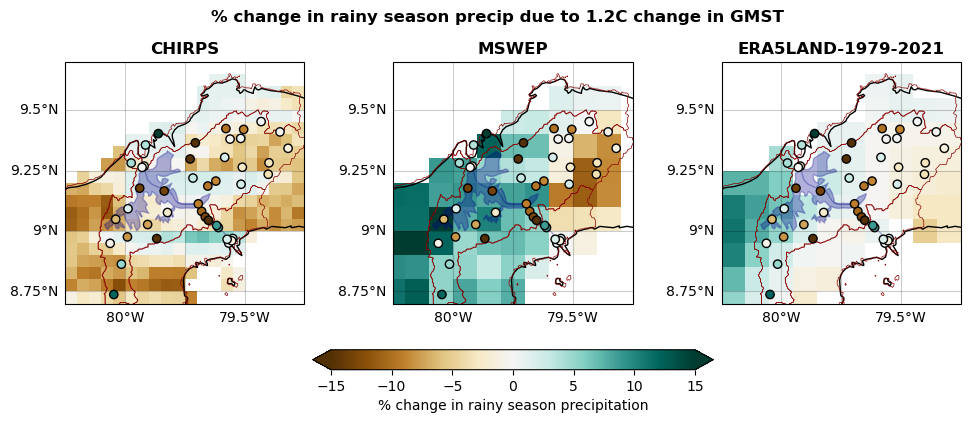

In [12]:
varnm = "dI_rel_hist"

fig, axs = plt.subplots(ncols = 3, figsize = (12.5,4), dpi = 100, subplot_kw={"projection" : mapproj, "extent" : [xn,xx,yn,yx]})
plt.subplots_adjust(wspace = 0.05)
cbar_kwargs = {"location" : "bottom", "fraction" : 0.065, "shrink" : 0.9, "pad" : 0.15, "extend" : "both"} | {"label" : label[varnm]}

for i in range(len(datasets)):
    ds = datasets[i]
    da = da_res[ds]
    ax = axs[i]
    
    cbar = da[varnm].plot(ax = ax, add_colorbar = False, **plot_kwargs[varnm])
    
    ax.scatter(stn_res.lon, stn_res.lat, c = stn_res[varnm], **plot_kwargs[varnm], zorder = 99, edgecolor = "k")

    ax.set_title(ds.upper(), fontweight = "bold")
    ax.coastlines()
    ax.add_feature(cartopy.feature.LAKES, color = "darkblue", alpha = 0.3)
    ax.add_feature(cartopy.feature.RIVERS, color = "darkblue", alpha = 0.3)
    ax.gridlines(color = "k", alpha = 0.2, draw_labels = ["left"], xlocs = np.arange(np.floor(xn),xx+0.5,0.25), ylocs = np.arange(np.floor(yn),yx+0.5,0.25))
    ax.gridlines(color = "k", alpha = 0, draw_labels = ["bottom"], xlocs = np.arange(np.floor(xn),xx+0.5,0.5))
    
    sf.boundary.plot(ax = ax, color = "darkred", lw = 0.5)
    
plt.colorbar(cbar, ax = axs, **cbar_kwargs)
plt.suptitle(main[varnm], fontweight = "bold", y = 1.01)
    
plt.savefig("fig/fitted-models-gridded_"+varnm+".png")

## Range of observed trends in station data

In [177]:
stn_res = merge_byindex([pd.read_csv("data/acp_stations.csv", index_col = 0)[["lon", "lat"]], 
                          pd.read_csv("res/res_rs_stations-filled_1979-2023.csv", index_col = 0).transpose()]).dropna(axis = 0, how = "any")

In [186]:
stn_res.dI_rel_neut.max()

-1.47667919420295

# Synthesis plots

In [8]:
# load synthesis data (produced in 3R_trend-fitting)
synth = {t+"_"+time : pd.read_csv("synthesis/synth_"+t+"_"+time+".csv", index_col = "model") for time in ["attr", "proj"] for t in ["pr", "di"]}

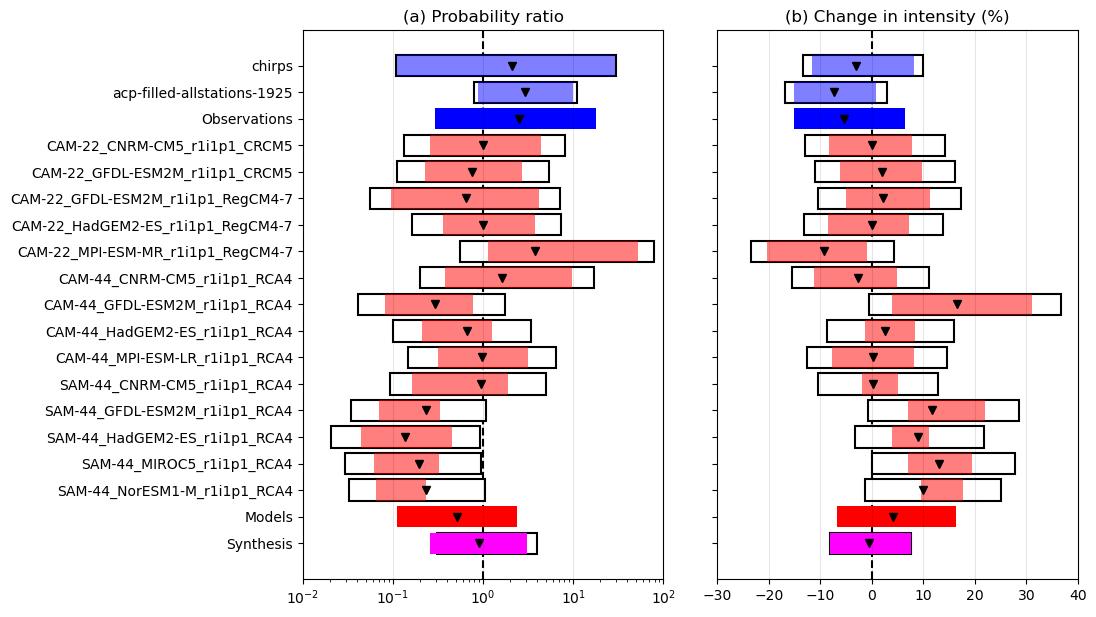

In [74]:
time = "attr"
units = "%"

pr_xlim = [10**-2,10**2]
di_xlim = [-30,40]

fig, axs = plt.subplots(ncols = 2, nrows = 1, figsize = (10,(len(synth["di_attr"]) * 3/8)), dpi = 100,
                        sharey = "row", sharex = "col")
plt.subplots_adjust(wspace = 0.15)

groups = ["obs", "obs_synth", "models", "model_synth", "synth"]
gcols = ["blue", "blue", "red", "red", "magenta"]
galpha = [0.5,1,0.5,1,1]

grp_kwargs = {grp : {"facecolor" : col, "alpha" : a} for grp, col, a in zip(groups, gcols, galpha)}

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

axs[0].axvline(1, color = "k", ls = "--", zorder = -99)
axs[1].axvline(0, color = "k", ls = "--", zorder = -99)

axs[0].set_xlim(*pr_xlim)
axs[1].set_xlim(*di_xlim)

for i in range(2):
    
    ax = axs[i]
    df = synth[["pr", "di"][i]+"_"+time]
    
    ttl = "("+["a","b"][i]+ ") "+["Probability ratio", "Change in intensity ("+units+")"][i]
    ax.set_title(ttl)
    
    ax.grid(axis = "x", color = "k", alpha = 0.1, ls = "-", zorder = -99)
    
    for k in range(len(df)):
            
        r = df.iloc[k]
        ax.add_patch(Rectangle((r.l_wb,-k-0.4), r.u_wb - r.l_wb, 0.8, edgecolor = "k", facecolor = "w", lw = 1.5))
        ax.add_patch(Rectangle((r.lower,-k-0.4), r.upper - r.lower, 0.8, **grp_kwargs[r.group]))
        ax.plot(r.est, -k, color = "k", marker = "v")  
        
axs[0].set_xscale('log')
axs[0].set_yticks(range(0, -len(synth["pr_"+time]), -1))
axs[0].set_yticklabels([re.sub('"', '', r).strip() for r in synth["pr_"+time].index])

plt.savefig("fig/synthesis_"+time+".png")

# Plots for comms

## Annual precip vs lake levels

In [42]:
chirps = xr.open_dataset("data/chirps05_panama.nc").pr.sel(lon = slice(xn,xx), lat = slice(yn, yx)).mean(["lon", "lat"]).resample(time = "AS-JAN").sum().sel(time = slice(None, "2023"))

In [69]:
lake = pd.read_csv("data/Download_Gatun_Lake_Water_Level_History.csv", parse_dates = ["DATE_LOG"], index_col = 0)
lake = lake.rename(columns = {"GATUN_LAKE_LEVEL(FEET)" : "level"}).loc[slice("1981", "2023")]
lake.loc[lake.level == 0, "level"] = np.nan # remove zeros
lake = lake.resample("AS-JAN").mean()

<BarContainer object of 43 artists>

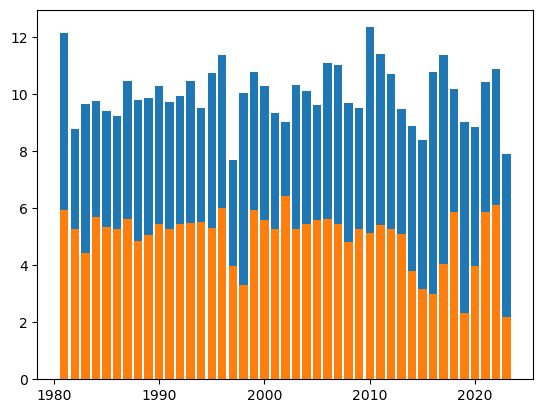

In [43]:
plt.bar(chirps.time.dt.year, (chirps - chirps.mean()) / chirps.std() + 10)
plt.bar(lake.index.year, (lake.level - lake.level.mean()) / lake.level.std() + 5)

## Precip vs Nino state

### Rainy season Nino3.4

In [267]:
df = merge_byindex([pd.read_csv("ts/panama_nino-rs.dat", comment = "#", sep = " ", header = None, index_col = 0, names = ["nino"]),
                    pd.read_csv("ts/panama_pr-rs_acp-filled-allstations-1900.dat", comment = "#", sep = " ", header = None, index_col = 0, names = ["pr"])])

(1500.0, 3522.3395454545453)

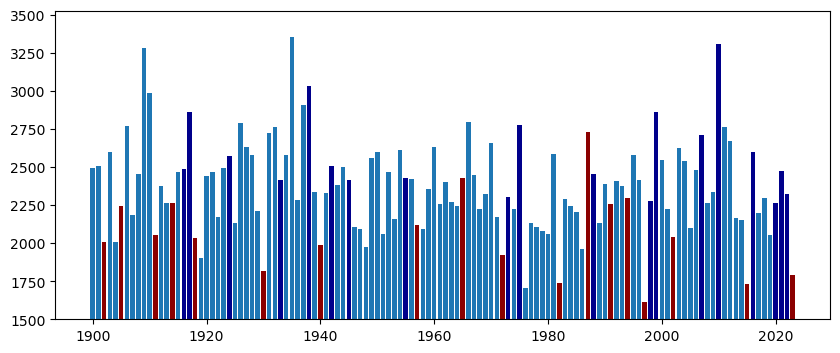

In [268]:
fig, ax = plt.subplots(figsize = (10,4), dpi = 100)
ax.bar(df.index, df.pr)
ax.bar(df.loc[df.nino >= 0.7].index, df.loc[df.nino >= 0.7].pr, color = "darkred")
ax.bar(df.loc[df.nino <= -0.7].index, df.loc[df.nino <= -0.7].pr, color = "darkblue")
ax.set_ylim(1500,None)

### BOM nino categories

(1500.0, 3522.3395454545453)

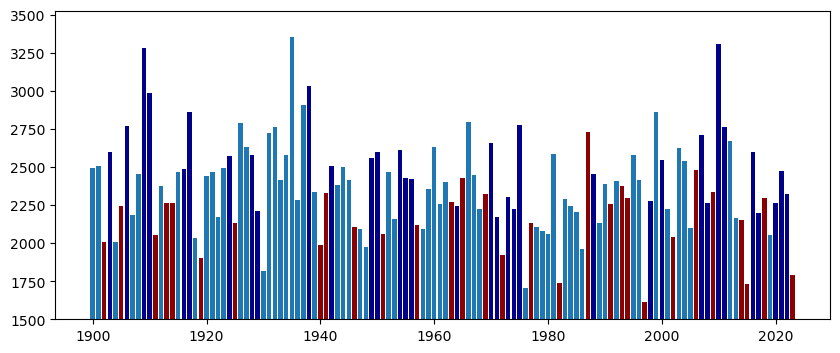

In [157]:
df = merge_byindex([pd.read_csv("ts/panama_nino-rs.dat", comment = "#", sep = " ", header = None, index_col = 0, names = ["nino"]),
                    pd.read_csv("ts/panama_pr-rs_acp-filled-allstations-1900.dat", comment = "#", sep = " ", header = None, index_col = 0, names = ["pr"])])

nino_bom = pd.read_csv("data/nino-bom.txt", comment = "#", sep = ": ", engine = "python")
nino_bom["ys"] = [int(y[:4]) for y in nino_bom.years]
nino_bom["ye"] = [int(y[:2]+y[-2:]) for y in nino_bom.years]

nino_bom["nino"] = [s[:2] for s in nino_bom.State]

nino_years = [y for r in [list(range(r.ys, r.ye)) for k, r in nino_bom.loc[nino_bom.nino == "El"].iterrows()] for y in r]
nina_years = [y for r in [list(range(r.ys, r.ye)) for k, r in nino_bom.loc[nino_bom.nino == "La"].iterrows()] for y in r]

fig, ax = plt.subplots(figsize = (10,4), dpi = 100)
ax.bar(df.index, df.pr)
ax.bar(df.loc[nino_years].index, df.loc[nino_years].pr, color = "darkred")
ax.bar(df.loc[nina_years].index, df.loc[nina_years].pr, color = "darkblue")
ax.set_ylim(1500,None)

### Combined

In [332]:
df = merge_byindex([pd.read_csv("ts/panama_nino-rs.dat", comment = "#", sep = " ", header = None, index_col = 0, names = ["nino"]),
                    pd.read_csv("ts/panama_pr-rs_acp-filled-allstations-1900.dat", comment = "#", sep = " ", header = None, index_col = 0, names = ["pr"]),
                    pd.read_csv("data/acp-allstations_fitted-trend.csv", index_col = 0)])

Text(0.5, 1.0, 'Low rainfall in Panama is associated with El Nino events.\n2023 was one of the driest years on record')

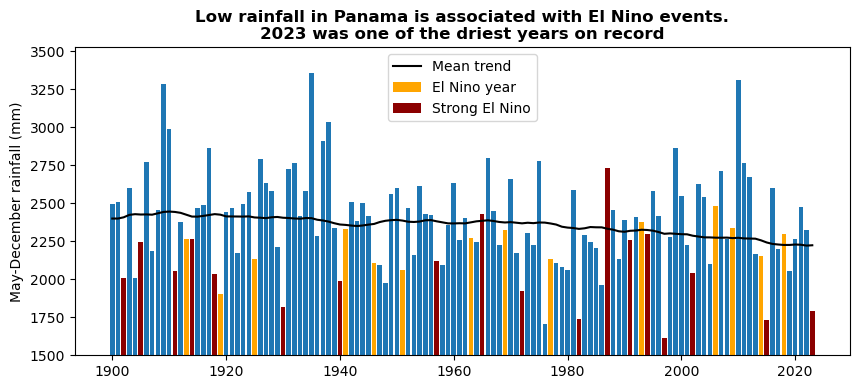

In [335]:
fig, ax = plt.subplots(figsize = (10,4), dpi = 100)
ax.bar(df.index, df.pr)
ax.bar(df.loc[nino_years].index, df.loc[nino_years].pr, color = "orange", label = "El Nino year")
ax.bar(df.loc[df.nino >= 0.7].index, df.loc[df.nino >= 0.7].pr, color = "darkred", label = "Strong El Nino")

ax.plot(df.index, df.trend, color = "k", label = "Mean trend")

# ax.bar(df.loc[nina_years].index, df.loc[nina_years].pr, color = "blue")
# ax.bar(df.loc[df.nino <= -0.7].index, df.loc[df.nino <= -0.7].pr, color = "darkblue")

# ax.bar(df.loc[nina_years].index, df.loc[nina_years].pr, color = "darkblue")
ax.set_ylim(1500,None)
ax.set_ylabel("May-December rainfall (mm)")
ax.legend()

ax.set_title("Low rainfall in Panama is associated with El Nino events.\n2023 was one of the driest years on record", fontweight = "bold")

In [334]:
df["nino_state"] = "-"
df.loc[nino_years, "nino_state"] = "nino"
df.loc[df.nino >= 0.7, "nino_state"] = "strong nino"
df.loc[slice("1900",None), ["pr", "nino_state", "trend"]].to_csv("data/precip-with-nino.csv")

# Figure for key messages

## Load lake level data

## Load 2023 anomaly data

In [146]:
# load lake level data
df = pd.read_csv("data/Download_Gatun_Lake_Water_Level_History.csv", parse_dates = ["DATE_LOG"], index_col = 0)
df = df.rename(columns = {"GATUN_LAKE_LEVEL(FEET)" : "level"})

df.loc[df.level == 0, "level"] = np.nan # remove zeros
df[np.abs(df - df.rolling(15).mean()) > 1] = np.nan # remove any readings that are more than 1ft from the smoothed line (seems implausible)

df_proj = pd.read_csv("data/Gatun_Water_Level_Projection.csv", skiprows = 3, header = None, names = ["proj_date", "level", "surcharge", "maxd_1", "maxd_2"],
           index_col = 0, parse_dates = [0]).sort_values("proj_date")[["level"]]

df_clim = df.loc[slice("1990", "2020")].groupby(df.loc[slice("1990", "2020")].index.day_of_year).mean()

In [147]:
# load data
chirps = xr.open_dataset("data/chirps_panama_monthly.nc").pr.sel(lon = slice(xn,xx), lat = slice(yn,yx)).resample(time = "AS-JAN").sum()
chirps = chirps.where(chirps > 0)

# compute climatology & anomaly
chirps_clim = chirps.sel(time = slice("1990", "2020")).mean("time")
chirps_2023 = chirps.sel(time = "2023").squeeze(drop = True)

chirps_anom = chirps_2023 - chirps_clim

In [148]:
# load station data, get annual mean (whole years only, require)
stn_pr = pd.read_csv("data/pr_stations_infilled.csv", index_col = 0, parse_dates = [0])
stn_ann = stn_pr.resample("AS-JAN").sum()
stn_ann = stn_ann.where(stn_pr.resample("AS-JAN").count() == 12)
stn_ann.index = stn_ann.index.year

# load lat & lon of all stations
stn_data = pd.read_csv("data/acp_stations.csv", index_col = 0)[["lon", "lat"]].dropna(axis = 0, how = "any")

# 2023 station data
stn_2023 = merge_byindex([stn_data, pd.DataFrame(stn_ann.loc[2023])]).dropna(axis = 0, how = "any")

# get station climatology (require min 20 years)
stn_clim = (stn_ann.loc[slice("1990", "2020")].mean().where(stn_ann.loc[slice("1990", "2020")].count() >= 20)).dropna(axis = 0, how = "any")
stn_clim = pd.DataFrame({"clim" : stn_clim})

stn_clim = merge_byindex([stn_data, stn_clim, stn_2023[[2023]]]).dropna(axis = 0, how = "any")

stn_clim["anom"] = stn_clim[2023] - stn_clim.clim

## Figure

/tmp/ipykernel_14953/3100822308.py:46: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(122, projection = mapproj, extent = [xn,xx,yn,yx])


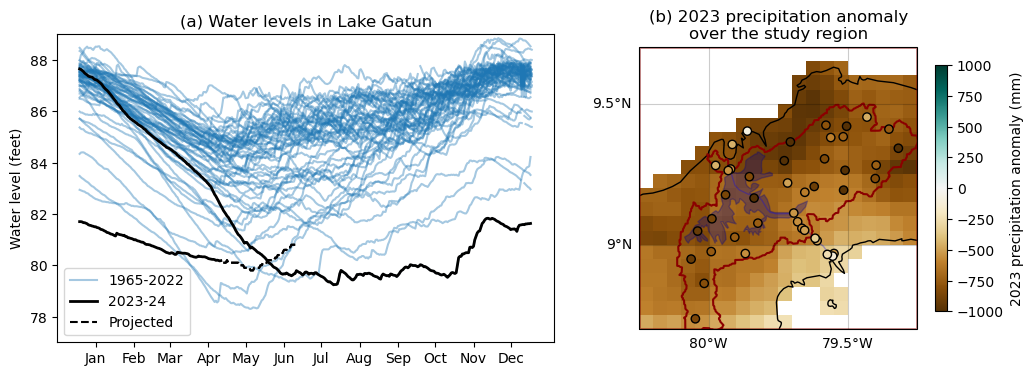

In [149]:
fig, axs =  plt.subplots(ncols = 2, figsize = (12,4), dpi = 100, gridspec_kw = {"width_ratios" : [3,2.1]})

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax = axs[0]

ts_y = df.loc[str(1965)]
ts_y.index = ts_y.index.day_of_year
ts_y.plot(ax = ax, color = "tab:blue", alpha = 0.4, legend = False, label = "_", zorder = -99)

ts_y = df.loc[str(2023)]
ts_y.index = ts_y.index.day_of_year
ts_y.plot(ax = ax, color = "k", legend = False, lw = 2)

for y in range(2024, 2025):
    ts_y = df_proj.loc[str(y)]
    ts_y.index = ts_y.index.day_of_year
    ts_y.plot(ax = ax, color = "k", ls = "--", legend = False)
    
for y in range(1966, 2024):
    ts_y = df.loc[str(y)]
    ts_y.index = ts_y.index.day_of_year
    ts_y.plot(ax = ax, color = "tab:blue", alpha = 0.4, legend = False, label = "_", zorder = -99)
    
ts_y = df.loc[str(2024)]
ts_y.index = ts_y.index.day_of_year
ts_y.plot(ax = ax, color = "k", legend = False, lw = 2)

for y in range(2024, 2025):
    ts_y = df_proj.loc[str(y)]
    ts_y.index = ts_y.index.day_of_year
    ts_y.plot(ax = ax, color = "k", ls = "--", legend = False)

# df_clim.plot(ax = ax, color = "darkblue", legend = False)
    
sc_xlabels(ax = ax, dates = df.loc["2020"].to_xarray().DATE_LOG, at_day = 15)
ax.legend(["1965-2022", "2023-24", "Projected"])
ax.set_ylim(77,89)

# ax.legend(["2023-24"], bbox_to_anchor = (0.9,0.6), loc = "center left", edgecolor = "w")
ax.set_xlabel("")
ax.set_ylabel("Water level (feet)")
ax.set_title("(a) Water levels in Lake Gatun")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

plt.subplot(122, projection = mapproj, extent = [xn,xx,yn,yx])
ax = plt.gca()

plot_kwargs = {"cmap" : "BrBG", "vmin" : -1000, "vmax" : 1000}

cbar = chirps_anom.plot(ax = ax, **plot_kwargs, add_colorbar = True, cbar_kwargs = {"shrink" : 0.8, "label" : "2023 precipitation anomaly (mm)"})
ax.scatter(stn_clim.lon, stn_clim.lat, c = stn_clim.anom, **plot_kwargs, zorder = 99, edgecolor = "k")

ax.coastlines()
ax.add_feature(cartopy.feature.LAKES, color = "darkblue", alpha = 0.3)
ax.add_feature(cartopy.feature.RIVERS, color = "blue", alpha = 0.3)
ax.gridlines(color = "k", alpha = 0.2, draw_labels = ["left", "bottom"], xlocs = np.arange(np.floor(xn),xx+0.5,0.5), ylocs = np.arange(np.floor(yn),yx+0.5,0.5))
ax.set_title("(b) 2023 precipitation anomaly\nover the study region")

ax.plot([xn,xn,xx,xx,xn], [yn,yx,yx,yn,yn], color = "darkred", lw = 2, alpha = 0.5)

sf.boundary.plot(ax = ax, color = "darkred")

plt.savefig("fig/key-message-fig.png")

# Event definition (seasonal anomaly)

In [167]:
# load data
chirps = xr.open_dataset("data/chirps_panama_monthly.nc").pr.sel(lon = slice(xn,xx), lat = slice(yn,yx))

ann = chirps.resample(time = "AS-JAN").sum()
ds = chirps.sel(time = [m <= 4 for m in chirps.time.dt.month]).resample(time = "AS-JAN").sum()
rs = chirps.sel(time = [m > 4 for m in chirps.time.dt.month]).resample(time = "AS-JAN").sum()

ann, ds, rs = [da.where(da > 0) for da in [ann, ds, rs]]

# compute climatology
ann_clim, ds_clim, rs_clim = [da.sel(time = slice("1990", "2020")).mean("time") for da in [ann, ds, rs]]
ann_2023, ds_2023, rs_2023 = [da.sel(time = "2023").squeeze(drop = True) for da in [ann, ds, rs]]

ann_anom = ann_2023 - ann_clim
ds_anom = ds_2023 - ds_clim
rs_anom = rs_2023 - rs_clim

In [175]:
# load lat & lon of all stations
stn_data = pd.read_csv("data/acp_stations.csv", index_col = 0)[["lon", "lat"]].dropna(axis = 0, how = "any")

# load station data
stn_pr = pd.read_csv("data/pr_stations_infilled.csv", index_col = 0, parse_dates = [0])

stn_ann = stn_pr.resample("AS-JAN").sum()
stn_ann = stn_ann.where(stn_pr.resample("AS-JAN").count() == 12)
stn_ann.index = stn_ann.index.year

stn_ds = stn_pr.rolling(4).sum().loc[stn_pr.index.month == 4]
stn_ds = stn_ds.where(stn_pr.rolling(4).count().loc[stn_pr.index.month == 4] == 4)
stn_ds.index = stn_ds.index.year

stn_rs = stn_pr.rolling(8).sum().loc[stn_pr.index.month == 12]
stn_rs = stn_rs.where(stn_pr.rolling(8).count().loc[stn_pr.index.month == 12] == 8)
stn_rs.index = stn_rs.index.year

In [176]:
# 2023 station data
stn_ann2023, stn_ds2023, stn_rs2023 = [merge_byindex([stn_data, pd.DataFrame(s.loc[2023])]).dropna(axis = 0, how = "any") for s in [stn_ann, stn_ds, stn_rs]]

In [177]:
# get station climatology (require min 20 years)
stn_annclim, stn_dsclim, stn_rsclim = [pd.DataFrame({"clim" : (s.loc[slice("1990", "2020")].mean().where(s.loc[slice("1990", "2020")].count() >= 20)).dropna(axis = 0, how = "any")}) for s in [stn_ann, stn_ds, stn_rs]]

In [179]:
stn_ann = merge_byindex([stn_data, stn_annclim, stn_ann2023[[2023]]]).dropna(axis = 0, how = "any")
stn_ds = merge_byindex([stn_data, stn_dsclim, stn_ds2023[[2023]]]).dropna(axis = 0, how = "any")
stn_rs = merge_byindex([stn_data, stn_rsclim, stn_rs2023[[2023]]]).dropna(axis = 0, how = "any")

In [180]:
stn_ann["anom"] = stn_ann[2023] - stn_ann.clim
stn_ds["anom"] = stn_ds[2023] - stn_ds.clim
stn_rs["anom"] = stn_rs[2023] - stn_rs.clim

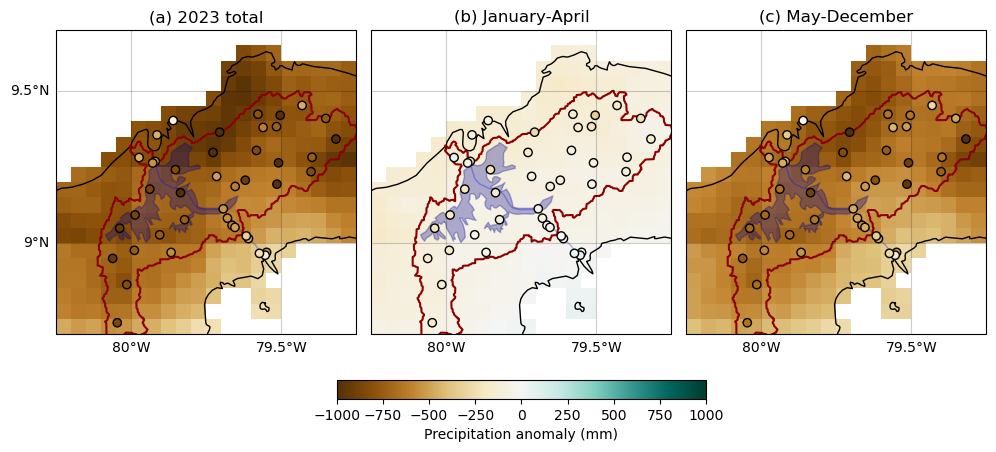

In [189]:
fig, axs = plt.subplots(ncols = 3, figsize = (12,6), subplot_kw = {"projection" : mapproj, "extent" : [xn,xx,yn,yx]}, sharex = True, sharey = True)
plt.subplots_adjust(wspace = 0.05)
plot_kwargs = {"cmap" : "BrBG", "vmin" : -1000, "vmax" : 1000}

titlestring = {"ann" : "2023 total", "ds" : "January-April", "rs" : "May-December"}

for i in range(3):
    ax = axs[i]
    s = ["ann", "ds", "rs"][i]
    stn = eval("stn_"+s)
    
    cbar = eval(s+"_anom").plot(ax = ax, **plot_kwargs, add_colorbar = False)
    ax.scatter(stn.lon, stn.lat, c = stn.anom, **plot_kwargs, zorder = 99, edgecolor = "k")
    ax.set_title("("+["a","b","c"][i]+") "+titlestring[s])
    
    ax.coastlines()
    ax.add_feature(cartopy.feature.LAKES, color = "darkblue", alpha = 0.3)
    ax.add_feature(cartopy.feature.RIVERS, color = "blue", alpha = 0.3)
    ax.gridlines(color = "k", alpha = 0.2, draw_labels = ["bottom"], xlocs = np.arange(np.floor(xn),xx+0.5,0.5), ylocs = np.arange(np.floor(yn),yx+0.5,0.5))
    sf.boundary.plot(ax = ax, color = "darkred")

axs[0].gridlines(color = "k", alpha = 0, draw_labels = ["left"], xlocs = np.arange(np.floor(xn),xx+0.5,0.5), ylocs = np.arange(np.floor(yn),yx+0.5,0.5))

plt.colorbar(cbar, ax = axs, location = "bottom", fraction = 0.04, pad = 0.1, label = "Precipitation anomaly (mm)")
plt.savefig("fig/event-map.png")

# Seasonal cycle & Nino/Nina years

In [187]:
# load daily time series over the region
chirps = xr.open_dataset("data/pr_monthly_chirps-catchment.nc").pr.sel(time = slice(None, "2023")).resample(time = "MS").sum()

acp = pd.read_csv("data/pr_stations_infilled.csv", index_col = 0, parse_dates = [0])
acp = acp.mean(axis = 1).dropna(axis = 0, how = "all")#.loc[slice("1979","2023")]

mmean = acp.groupby(acp.index.month).mean()
msd = acp.groupby(acp.index.month).std()

m_upper = mmean+msd
m_lower = mmean-msd

In [194]:
(acp.rolling(8).sum().loc[acp.index.month == 12] / acp.rolling(12).sum().loc[acp.index.month == 12]).mean()

0.9084859396048792

In [161]:
# load precip & Nino/Nina years
df = merge_byindex([pd.read_csv("ts/panama_nino-rs.dat", comment = "#", sep = " ", header = None, index_col = 0, names = ["nino"]),
                    pd.read_csv("ts/panama_pr-rs_acp-filled-allstations-1900.dat", comment = "#", sep = " ", header = None, index_col = 0, names = ["pr"])])

df = df.loc[slice("1950",None)]

nino_bom = pd.read_csv("data/nino-bom.txt", comment = "#", sep = ": ", engine = "python")

nino_bom["ys"] = [int(y[:4]) for y in nino_bom.years]
nino_bom["ye"] = [int(y[:2]+y[-2:]) for y in nino_bom.years]
nino_bom["nino"] = [s[:2] for s in nino_bom.State]

nino_bom = nino_bom.loc[nino_bom.ys >= 1950]

nino_years = [y for r in [list(range(r.ys, r.ye)) for k, r in nino_bom.loc[nino_bom.nino == "El"].iterrows()] for y in r]
nina_years = [y for r in [list(range(r.ys, r.ye)) for k, r in nino_bom.loc[nino_bom.nino == "La"].iterrows()] for y in r]

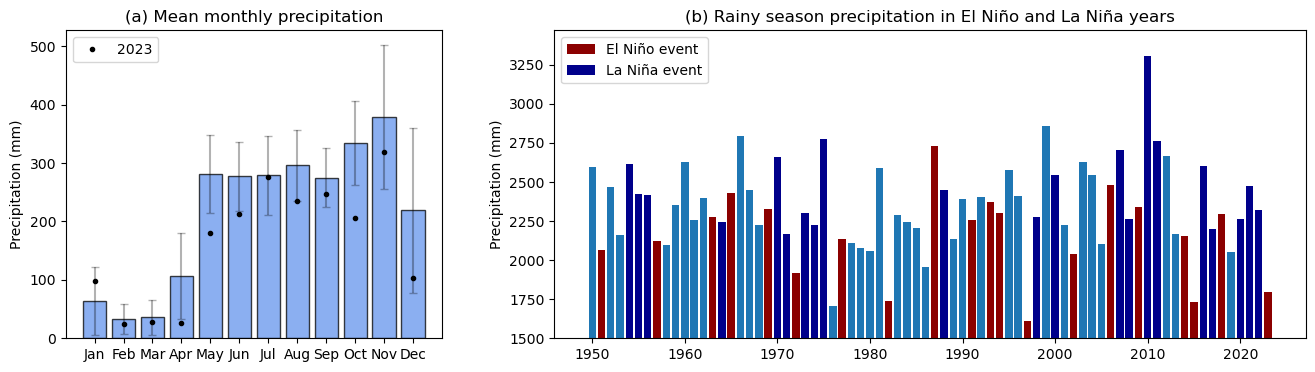

In [162]:
fig, axs = plt.subplots(ncols = 2, figsize = (16,4), dpi = 100, gridspec_kw = {"width_ratios" : [1,2]})

ax = axs[0]
ax.bar(mmean.index, mmean, color = "cornflowerblue", edgecolor = "k", alpha = 0.75)
for m in range(12):
    ax.plot([m+1,m+1], [m_lower.iloc[m], m_upper.iloc[m]], color = "k", alpha = 0.3, marker = "_", solid_capstyle = "butt")

ax.set_ylabel("Precipitation (mm)")

ax.set_xticks(range(13)[1:])
ax.set_xticklabels(acp.loc["2023"].index.strftime("%b").values)
ax.plot(acp.loc["2023"].index.month, acp.loc["2023"], marker = ".", ls = "", color = "k", label = "2023")
ax.legend()
ax.set_title("(a) Mean monthly precipitation")


ax = axs[1]
ax.bar(df.index, df.pr)
ax.bar(df.loc[nino_years].index, df.loc[nino_years].pr, color = "darkred", label = "El Niño event")
ax.bar(df.loc[nina_years].index, df.loc[nina_years].pr, color = "darkblue", label = "La Niña event")
ax.set_ylim(1500,None)
ax.set_title("(b) Rainy season precipitation in El Niño and La Niña years")
ax.set_ylabel("Precipitation (mm)")
ax.legend(loc = "upper left")

plt.savefig("fig/fig_1-1.png", dpi = 100)

# Lake levels

In [140]:
# load lake level data
df = pd.read_csv("data/Download_Gatun_Lake_Water_Level_History.csv", parse_dates = ["DATE_LOG"], index_col = 0)
df = df.rename(columns = {"GATUN_LAKE_LEVEL(FEET)" : "level"})

df.loc[df.level == 0, "level"] = np.nan # remove zeros
df[np.abs(df - df.rolling(15).mean()) > 1] = np.nan # remove any readings that are more than 1ft from the smoothed line (seems implausible)

df_proj = pd.read_csv("data/Gatun_Water_Level_Projection.csv", skiprows = 3, header = None, names = ["proj_date", "level", "surcharge", "maxd_1", "maxd_2"],
           index_col = 0, parse_dates = [0]).sort_values("proj_date")[["level"]]

df_clim = df.loc[slice("1990", "2020")].groupby(df.loc[slice("1990", "2020")].index.day_of_year).mean()

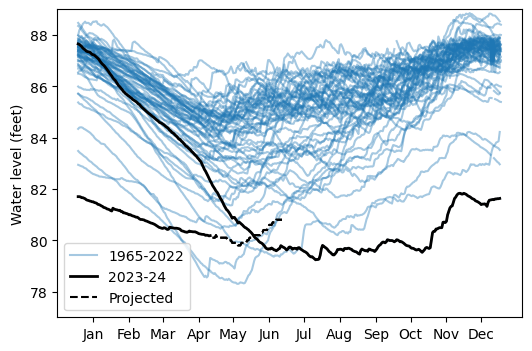

In [145]:
fig, ax =  plt.subplots(ncols = 1, figsize = (6,4), dpi = 100)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

ts_y = df.loc[str(1965)]
ts_y.index = ts_y.index.day_of_year
ts_y.plot(ax = ax, color = "tab:blue", alpha = 0.4, legend = False, label = "_", zorder = -99)

ts_y = df.loc[str(2023)]
ts_y.index = ts_y.index.day_of_year
ts_y.plot(ax = ax, color = "k", legend = False, lw = 2)

for y in range(2024, 2025):
    ts_y = df_proj.loc[str(y)]
    ts_y.index = ts_y.index.day_of_year
    ts_y.plot(ax = ax, color = "k", ls = "--", legend = False)
    
for y in range(1966, 2024):
    ts_y = df.loc[str(y)]
    ts_y.index = ts_y.index.day_of_year
    ts_y.plot(ax = ax, color = "tab:blue", alpha = 0.4, legend = False, label = "_", zorder = -99)
    
ts_y = df.loc[str(2024)]
ts_y.index = ts_y.index.day_of_year
ts_y.plot(ax = ax, color = "k", legend = False, lw = 2)

for y in range(2024, 2025):
    ts_y = df_proj.loc[str(y)]
    ts_y.index = ts_y.index.day_of_year
    ts_y.plot(ax = ax, color = "k", ls = "--", legend = False)

# df_clim.plot(ax = ax, color = "darkblue", legend = False)
    
sc_xlabels(ax = ax, dates = df.loc["2020"].to_xarray().DATE_LOG, at_day = 15)
ax.legend(["1965-2022", "2023-24", "Projected"])
ax.set_ylim(77,89)

# ax.legend(["2023-24"], bbox_to_anchor = (0.9,0.6), loc = "center left", edgecolor = "w")
ax.set_xlabel("")
ax.set_ylabel("Water level (feet)")

plt.savefig("fig/lake-levels.png")

# How wet was 2023?


In [165]:
acp = pd.read_csv("ts/panama_pr-rs_acp-filled-allstations.dat", comment = "#", sep = " ", header = None, index_col = 0, names = ["pr"])

In [172]:
acp = pd.merge(acp, pd.DataFrame(index = nino_years, data = {"state" : "nino"}), left_index = True, right_index = True, how = "outer")

In [173]:
acp.sort_values("pr").iloc[:10]

,pr,state
1997,1612.800000,nino
1976,1705.525000,NaN
2015,1731.136364,nino
1982,1740.579545,nino
2023,1793.090909,nino
1930,1814.877273,NaN
1919,1899.647727,NaN
1972,1919.138636,nino
1883,1936.727273,NaN
1896,1956.797727,NaN
